In [1]:
# Importing Necessary Libraries
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function for Formatting Dataset
def FormatDataset(dataset_src, dataset_dest, classes):
    # Making a Copy of Dataset
    new_cropped_dest = [os.path.join(dataset_dest, cls, 'CROPPED') for cls in classes];
    new_complete_dest = [os.path.join(dataset_dest, cls, 'COMPLETE') for cls in classes];
    cropped_src = [ dataset_src + "/im_" + cls + "/im_" + cls + "/CROPPED" for cls in classes ];
    complete_src = [ dataset_src + "/im_" + cls + "/im_" + cls for cls in classes ];
    for (dest1, dest2) in zip(new_cropped_dest, new_complete_dest):
        os.makedirs(dest1);
        os.makedirs(dest2);
    # Formating Cropped Images
    for (src,new_dest) in zip(cropped_src, new_cropped_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (64, 64));
                img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0);
                img = cv2.blur(img, (2, 2));
                cv2.imwrite(img_des ,img);
    # Formatting Complete Images
    for (src,new_dest) in zip(complete_src, new_complete_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (256, 256));
                img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0);
                img = cv2.blur(img, (2, 2));
                cv2.imwrite(img_des ,img);

# Source Location for Dataset
src = 'F:/test3/input/cervical-cancer-largest-dataset-sipakmed';
# Destination Location for Dataset
dest = 'F:/test3/CervicalCancer';
# Image Classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"];
# Formatting Dataset
FormatDataset(src, dest, classes);

In [3]:
root_dir = "F:/test3/CervicalCancer"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

def GetDatasetSize(path, classes, main = "CROPPED"):
    num_of_image = {}
    for cls in classes:
        # Counting the Number of Files in the Folder
        num_of_image[cls] = len(os.listdir(os.path.join(path, cls, main)));
    return num_of_image;

print(GetDatasetSize(root_dir, classes, "COMPLETE"));

{'Dyskeratotic': 223, 'Koilocytotic': 238, 'Metaplastic': 271, 'Parabasal': 108, 'Superficial-Intermediate': 126}


### Split the Dataset such that we have
* 70% for Train Data
* 15% for Validation Data
* 15% for Testing Data

In [4]:
# Function for Creating Train / Validation / Test folders (One time use Only)

def TrainValTestSplit(root_dir, classes_dir, main = "CROPPED", val_ratio = 0.15, test_ratio = 0.15):
    for cls in classes_dir:
        # Creating Split Folders
        os.makedirs('train/' + cls)
        os.makedirs('val/' + cls)
        os.makedirs('test/' + cls)

        # Folder to copy images from
        src = os.path.join(root_dir, cls, main);

        # Spliting the Files in the Given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        # Printing the Split Details
        print(cls,':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, 'train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, 'val/' + cls)

        for name in test_FileNames:
            shutil.copy(name, 'test/' + cls)
        print();
        

# Preforming Train / Validation / Test Split
root_dir = "./CervicalCancer"               # Dataset Root Folder
classes_dir = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]   # Classes
TrainValTestSplit(root_dir, classes_dir);

Dyskeratotic :
Total images:  813
Training:  569
Validation:  122
Testing:  122

Koilocytotic :
Total images:  825
Training:  577
Validation:  124
Testing:  124

Metaplastic :
Total images:  793
Training:  555
Validation:  119
Testing:  119

Parabasal :
Total images:  787
Training:  550
Validation:  118
Testing:  119

Superficial-Intermediate :
Total images:  831
Training:  581
Validation:  125
Testing:  125



### Building Model 


In [5]:
# Importing Keras for Image Classification
import keras
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout,BatchNormalization
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input

In [6]:



base_model = ResNet50(weights='imagenet', include_top=False)

# Define the input layer matching the ResNet-50 architecture (224x224x3 for ResNet-50)
input_tensor = Input(shape=(224, 224, 3))

# Build your custom top classification layers
x = base_model(input_tensor)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(5, activation='sigmoid')(x)  # Adjust 5 to the number of your output classes

# Create the customized model
model = Model(inputs=input_tensor, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 23,719,173
Trainable params: 23,666,053
Non-trainable params: 53,120
____________________________________________

### Preparing data using data generator 

In [7]:
# Expand the size of dataset with new transformed images from the original dataset using ImageDataGenerator.
train_datagen = image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [8]:
train_data = train_datagen.flow_from_directory(directory= "F:/test3/train", target_size=(64, 64), batch_size=100, class_mode = 'categorical')

Found 2832 images belonging to 5 classes.


In [9]:
train_data.class_indices

{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [10]:
val_data = val_datagen.flow_from_directory(directory= "F:/test3/val", target_size=(64, 64), batch_size=100, class_mode = 'categorical')

Found 608 images belonging to 5 classes.


In [11]:
test_data = test_datagen.flow_from_directory(directory= "F:/test3/test", target_size=(64, 64), batch_size=100, class_mode = 'categorical')

Found 609 images belonging to 5 classes.


In [12]:
# Adding Model check point Callback
mc = ModelCheckpoint(filepath="cervical_cancer_best_model.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back = [ mc ];

In [13]:
# Fitting the Model
cnn = model.fit(train_data, 
                  steps_per_epoch= 28, 
                  epochs= 32,
                  validation_data= val_data, 
                  validation_steps= 6,
                  callbacks = call_back )

Epoch 1/32
28/28 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.8119
Epoch 1: val_accuracy improved from -inf to 0.19333, saving model to cervical_cancer_best_model.hdf5
28/28 [==============================] - 78s 2s/step - loss: 0.5443 - accuracy: 0.8119 - val_loss: 151.3094 - val_accuracy: 0.1933
Epoch 2/32
28/28 [==============================] - ETA: 0s - loss: 0.2641 - accuracy: 0.9173
Epoch 2: val_accuracy improved from 0.19333 to 0.20667, saving model to cervical_cancer_best_model.hdf5
28/28 [==============================] - 74s 3s/step - loss: 0.2641 - accuracy: 0.9173 - val_loss: 176.2263 - val_accuracy: 0.2067
Epoch 3/32
28/28 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9396
Epoch 3: val_accuracy did not improve from 0.20667
28/28 [==============================] - 61s 2s/step - loss: 0.1897 - accuracy: 0.9396 - val_loss: 378.8815 - val_accuracy: 0.2033
Epoch 4/32
28/28 [==============================] - ETA: 0s - loss: 0

In [14]:
# Loading the Best Fit Model 
model = load_model("./cervical_cancer_best_model.hdf5")

### Model Accuracy

In [15]:
# Checking the Accuracy of the Model 
accuracy = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of your model is = {accuracy*100} %")


The accuracy of your model is = 76.1904776096344 %


In [16]:
h =  cnn.history;
h.keys();

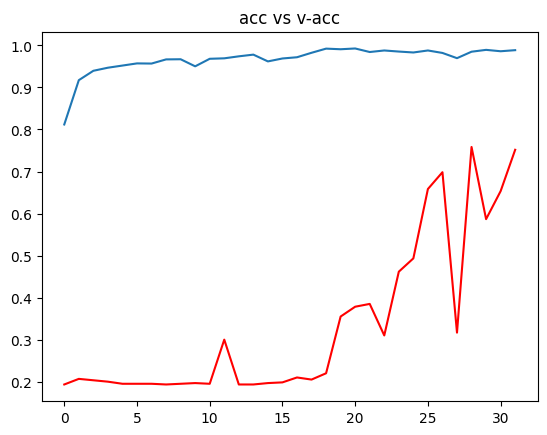

In [17]:
# Ploting Accuracy In Training Set & Validation Set

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

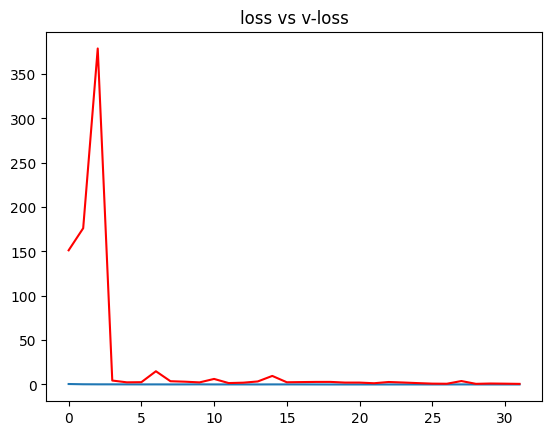

In [18]:
# Ploting Loss In Training Set & Validation Set

plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [22]:
import keras.utils as image
def cancerPrediction(path):
    classes_dir = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
    # Loading Image
    img = image.load_img(path, target_size=(64,64))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(model.predict(input_arr_img))
    # Printing Model Prediction
    print(classes_dir[pred])

path = "F:/test3/test/Koilocytotic/015_03.jpg"
cancerPrediction(path)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Fazlea Rabbi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Fazlea Rabbi\AppData\Local\Temp\ipykernel_21512\2048031306.py", line 21, in <module>
    cancerPrediction(path)
  File "C:\Users\Fazlea Rabbi\AppData\Local\Temp\ipykernel_21512\2048031306.py", line 15, in cancerPrediction
    pred = np.argmax(model.predict(input_arr_img))
  File "C:\Users\Fazlea Rabbi\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\FAZLEA~1\AppData\Local\Temp\__autograph_generated_filea04m35v4.py", line 15, in tf__predict_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\Users\Fazlea Rabbi\AppD